In [46]:
%load_ext autoreload
%autoreload 2

from scipy.interpolate import griddata
import numpy as np
from scipy.ndimage import gaussian_filter #從 scipy.ndimage 導入 gaussian_filter
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4 as nc
import h5py
from numba import jit,njit,prange
from numpy import linalg
from time import sleep
from tqdm import tqdm, trange
import torch, torch.linalg
from tqdm import tqdm
import shutil
from time import gmtime, strftime
from scipy.fft import *
import matplotlib
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
import xarray as xr
from scipy.interpolate import *

import funcs as fff
# for latex style 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from os import environ

environ['OMP_NUM_THREADS'] = '1'

from scipy.spatial import distance_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
#data = xr.open_dataset('/work/DATA/CMIP6/freq_day/precipitation_flux/TaiESM1/pr_day_TaiESM1_historical_r1i1p1f1_gn_20000101-20091231.nc')
data = xr.open_dataset('/work/DATA/CMIP6/freq_day/precipitation_flux/CMCC-CM2-SR5/pr_day_CMCC-CM2-SR5_historical_r1i1p1f1_gn_19750101-19991231.nc')


In [48]:
data

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 9125, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 73kB 1975-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 146kB ...
    lat_bnds   (lat, bnds) float64 3kB ...
    lon_bnds   (lon, bnds) float64 5kB ...
    pr         (time, lat, lon) float32 2GB ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                none
    ...                     ...
    title:                  CMCC-CM2-SR5 output prepared for CMIP6
    variable_id:            pr
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/f7682192-948a-4692-8b13-11e83738cc59

In [49]:
clim    = data['pr'].groupby('time.dayofyear').mean('time')
anomaly_tmp = data['pr'].groupby('time.dayofyear') - clim 

lon = data['lon']


#clim    = data['precipitation'].groupby('time.dayofyear').mean('time')
#anomaly_tmp = data['precipitation'].groupby('time.dayofyear') - clim 

In [50]:
time = data['time'].to_numpy()

In [51]:
print(anomaly_tmp.shape)
anomaly = anomaly_tmp.sel(lat=slice(-15.0, 15.0))
anomaly.shape

(9125, 192, 288)


(9125, 32, 288)

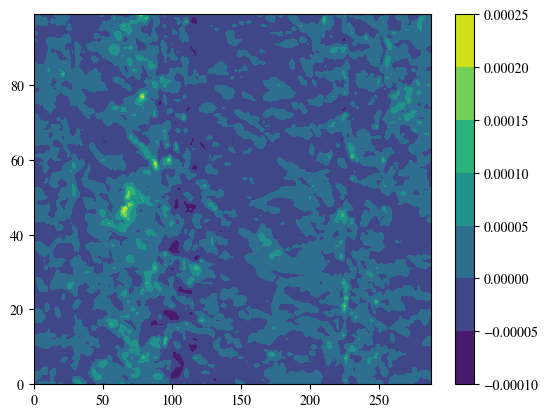

In [52]:
# Weighted mean ! 

anomaly_wtedmean = weighted_mean(anomaly)

plt.contourf(anomaly_wtedmean[:100,:])
plt.colorbar()

In [36]:
def smooth_x(x,c,dx): 
    sig_fft = fft(x)
    sig_fft_filtered = sig_fft.copy()
    freq = fftfreq(len(x), dx)
    cut_off = c
    sig_fft_filtered[np.abs(freq) > cut_off] = 0
    filtered = ifft(sig_fft_filtered)
    return filtered 


def smooth_t(x,c_min,c_max,dt):
    sig_fft = fft(x)
    sig_fft_filtered = sig_fft.copy()
    freq = fftfreq(len(x), dt)
    
    sig_fft_filtered[np.abs(freq) > c_max] = 0
    sig_fft_filtered[np.abs(freq) < c_min] = 0
    
    filtered = ifft(sig_fft_filtered)
    return filtered

In [43]:
smoothen_ano = np.zeros_like(anomaly)
# time, lat, lon  
shp = anomaly.shape

for i in range(shp[1]): 
    ffted_data = fftn(anomaly[:,i,:].to_numpy())
    freq_t     = fftfreq(shp[0],d=1) #day
    freq_t     = np.where( (freq_t>(-1/20)) & (freq_t<(-1/100)) ,1,0)

    #freq_x     = fftfreq(shp[2],d=1)
    #kx = fftfreq(Nlon, d=dlon)
    kx         = fftfreq(shp[2], d=1.25)
    freq_x     = np.where(kx<10,1,0)

    xx,tt = np.meshgrid(freq_x,freq_t) 
    print(tt.shape,xx.shape)
    temp2  = np.where((tt+xx)>1.1,ffted_data,0)
    
    smoothen_ano[:,i,:] = ifftn(temp2) 
    
    

(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)


/tmp/ipykernel_1021741/2776636864.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  smoothen_ano[:,i,:] = ifftn(temp2)


(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)
(9125, 288) (9125, 288)


Text(0.5, 1.0, 'Precip. Flux')

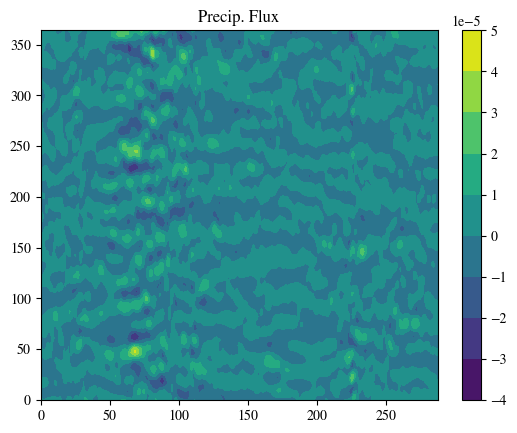

In [44]:
smoothen_ano.shape
smoothen_ano_ave = np.mean(smoothen_ano,axis=1)
plt.contourf(smoothen_ano_ave[:365,:])
plt.colorbar()
plt.title('Precip. Flux')
#plt.xlim(60,120)
#plt.colorbar()

In [13]:
sigma_p = np.std(smoothen_ano_ave,axis=0)
sigma_p.shape

(288,)

In [14]:
def fill_gap(arr,gap_threshold):
    # Step 1: find where gaps are
    is_gap = arr == 0
    
    # Step 2: identify gap runs using np.diff
    gap_starts = np.where(np.diff(np.concatenate(([0], is_gap.astype(int)))) == 1)[0]
    gap_ends = np.where(np.diff(np.concatenate((is_gap.astype(int), [0]))) == -1)[0]
    
    # Step 3: fill gaps that are smaller than the threshold
    for start, end in zip(gap_starts, gap_ends):
        if (end - start) <= gap_threshold:
            arr[start:end+1] = 1
    
    return arr 

def A(t0,x0,s_slope,xx):  # draw the line with given s 
    return s_slope*(xx - x0*np.ones(len(xx)) ) + t0 

def biggest_conn_component(arr):
    # Step 1: find where gaps are
    is_gap = arr == 1  # originally, gap=0, now we set gap=1 to get connected component 
    
    # Step 2: identify gap runs using np.diff
    gap_starts = np.where(np.diff(np.concatenate(([0], is_gap.astype(int)))) == 1)[0]
    gap_ends = np.where(np.diff(np.concatenate((is_gap.astype(int), [0]))) == -1)[0]

    try: 
        idx = np.argmax(gap_ends-gap_starts)
        return gap_starts[idx], gap_ends[idx]
    except: 
        return 0,0
    
    

In [15]:
def get_intensity(s,t0): 

    tt = np.arange(0,shp[0],1)
    xx = np.arange(0,shp[2],1)

    points = (tt,xx) 
    
    s_slope = s*((6400*1000)/(shp[2]*86400)) # lon/day 
    #print(s_slope)
    
    t_line = A(t0,70,s_slope,xx) 
    
    
    
    temp  = interpn(points, smoothen_ano_ave , (t_line[t_line>0],xx[t_line>0])  )
    temp2 = np.where((temp-sigma_p[t_line>0])>0,1,0)
    
    #plt.plot(xx[t_line>0],temp)
    #plt.plot(xx,sigma_p)
    dlon = lon[1]-lon[0]
    #print(dlon)
    #plt.plot(xx[t_line>0],temp2)
    
    temp3 = fill_gap(temp2,round(10/dlon.item()) )
    #plt.plot(xx[t_line>0],temp3)
    
    idx_b,idx_t = biggest_conn_component(temp3)
    
    big_segment_xx = xx[t_line>0][idx_b:idx_t]
    big_segment_tt = A(t0,70,s_slope,big_segment_xx)
    big_segment_pp = interpn(points, smoothen_ano_ave , (big_segment_tt,big_segment_xx)  )
    
    intensity = np.trapz(big_segment_pp, big_segment_xx,dx = 1+s_slope**2  )
    return intensity


In [16]:
num_speed = 16 
num_time  = 1000 
sss = np.linspace(0.5,num_speed,num_speed*2)
ttt = np.arange(0,num_time+0.01,1)

intensity_hoff = np.zeros((len(sss),len(ttt))) 
for i in range(len(sss)): 
    for j in range(len(ttt)): 
        intensity_hoff[i,j] = get_intensity(sss[i],ttt[j])


(700.0, 770.0)

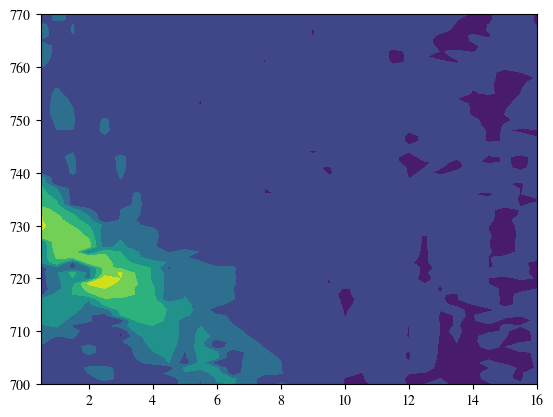

In [28]:
plt.contourf(sss,ttt,intensity_hoff.T)
plt.ylim(700,770)

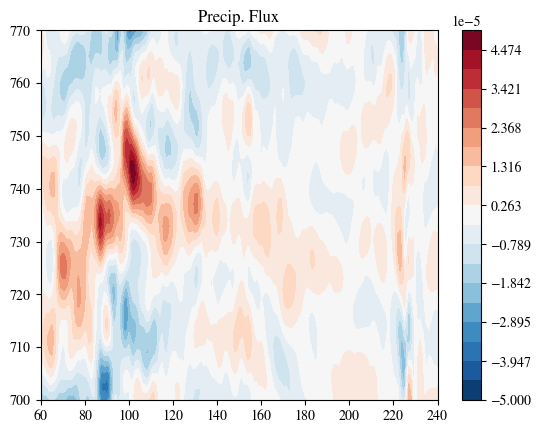

In [27]:
smoothen_ano.shape
smoothen_ano_ave = np.mean(smoothen_ano,axis=1)
plt.contourf(smoothen_ano_ave[:,:],levels=np.linspace(-0.5*1e-4,0.5*1e-4,20),cmap='RdBu_r')
plt.title('Precip. Flux')
plt.ylim(700,770)
plt.xlim(60,240)
plt.colorbar()